# Migration Flows with pytidycensus

This notebook demonstrates how to use the `get_flows()` function in pytidycensus to retrieve migration flow data from the Census Migration Flows API.

The Migration Flows API provides data on population movement between geographic areas based on American Community Survey (ACS) 5-year estimates.

In [2]:
import pytidycensus as tc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytidycensus as tc
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Set your Census API key
# tc.set_census_api_key("your_key_here")

## Basic County-to-County Migration Flows

Let's start with basic county-to-county migration flows for Texas:

In [3]:
# Get county-to-county migration flows for Texas
tx_flows = tc.get_flows(
    geography="county",
    state="TX",
    year=2018,
    output="wide"
)

print(f"Shape: {tx_flows.shape}")
print(f"Columns: {list(tx_flows.columns)}")
tx_flows.head()

Shape: (36641, 10)
Columns: ['GEOID1', 'GEOID2', 'FULL1_NAME', 'FULL2_NAME', 'MOVEDIN', 'MOVEDIN_M', 'MOVEDOUT', 'MOVEDOUT_M', 'MOVEDNET', 'MOVEDNET_M']


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M,MOVEDOUT,MOVEDOUT_M,MOVEDNET,MOVEDNET_M
0,48001,None,"Anderson County, Texas",Africa,38,52.0,NaN,NaN,NaN,NaN
1,48001,None,"Anderson County, Texas",Asia,4,6.0,NaN,NaN,NaN,NaN
2,48001,None,"Anderson County, Texas",Central America,2,3.0,NaN,NaN,NaN,NaN
3,48001,01089,"Anderson County, Texas","Madison County, Alabama",13,20.0,0.0,28.0,13.0,20.0
4,48001,02016,"Anderson County, Texas","Aleutians West Census Area, Alaska",0,31.0,7.0,9.0,-7.0,9.0


## Understanding the Data Structure

Each row represents a flow between two counties:
- `GEOID1` and `FULL1_NAME`: Origin county
- `GEOID2` and `FULL2_NAME`: Destination county  
- `MOVEDIN`: People who moved from county 1 to county 2
- `MOVEDOUT`: People who moved from county 2 to county 1
- `MOVEDNET`: Net migration (positive = more moved to county 2)
- Variables ending in `_M`: Margin of error

In [4]:
# Look at the largest migration flows
largest_flows = tx_flows.nlargest(10, 'MOVEDIN')
print("Top 10 largest migration flows:")
largest_flows[['FULL1_NAME', 'FULL2_NAME', 'MOVEDIN', 'MOVEDIN_M']].head()

Top 10 largest migration flows:


,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M
12973,"Fort Bend County, Texas","Harris County, Texas",20139,1842.0
30609,"Tarrant County, Texas","Dallas County, Texas",19149,1603.0
10162,"Denton County, Texas","Dallas County, Texas",18807,2114.0
15530,"Harris County, Texas",Asia,18170,1557.0
6588,"Collin County, Texas","Dallas County, Texas",17264,1567.0


## Tidy Format for Analysis

The tidy format is better for analysis and visualization:

In [5]:
# Get the same data in tidy format
tx_flows_tidy = tc.get_flows(
    geography="county",
    state="TX", 
    year=2018,
    output="tidy"
)

print(f"Tidy format shape: {tx_flows_tidy.shape}")
tx_flows_tidy.head()

Tidy format shape: (109923, 7)


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,variable,estimate,moe
0,48001,None,"Anderson County, Texas",Africa,MOVEDIN,38.0,52.0
1,48001,None,"Anderson County, Texas",Africa,MOVEDOUT,NaN,NaN
2,48001,None,"Anderson County, Texas",Africa,MOVEDNET,NaN,NaN
3,48001,None,"Anderson County, Texas",Asia,MOVEDIN,4.0,6.0
4,48001,None,"Anderson County, Texas",Asia,MOVEDOUT,NaN,NaN


In [6]:
# Analyze migration patterns
migration_summary = tx_flows_tidy.groupby('variable')['estimate'].agg(['sum', 'mean', 'std'])
print("Migration flow summary:")
migration_summary

Migration flow summary:


,sum,mean,std
variable,,,
MOVEDIN,1920233.0,52.406676,384.593025
MOVEDNET,130846.0,3.637744,147.398580
MOVEDOUT,1575040.0,43.788818,347.139862


## Migration Flows with Demographic Breakdowns

**Note**: Breakdown characteristics are only available for years 2006-2015.

In [7]:
# Get flows with age and sex breakdowns (2015 data)
ri_flows_breakdown = tc.get_flows(
    geography="county",
    breakdown=["AGE", "SEX"],
    breakdown_labels=True,
    state="RI",
    year=2015,  # Breakdown only available before 2016
    output="tidy"
)

print(f"With breakdowns shape: {ri_flows_breakdown.shape}")
print(f"Breakdown columns: {[col for col in ri_flows_breakdown.columns if 'label' in col]}")
ri_flows_breakdown.head()

With breakdowns shape: (63072, 11)
Breakdown columns: ['AGE_label', 'SEX_label']


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,AGE,SEX,AGE_label,SEX_label,variable,estimate,moe
0,44001,None,"Bristol County, Rhode Island",Asia,00,00,All ages,All sexes,MOVEDIN,58.0,49.0
1,44001,None,"Bristol County, Rhode Island",Asia,00,00,All ages,All sexes,MOVEDOUT,NaN,NaN
2,44001,None,"Bristol County, Rhode Island",Asia,00,00,All ages,All sexes,MOVEDNET,NaN,NaN
3,44001,None,"Bristol County, Rhode Island",Europe,00,00,All ages,All sexes,MOVEDIN,197.0,170.0
4,44001,None,"Bristol County, Rhode Island",Europe,00,00,All ages,All sexes,MOVEDOUT,NaN,NaN


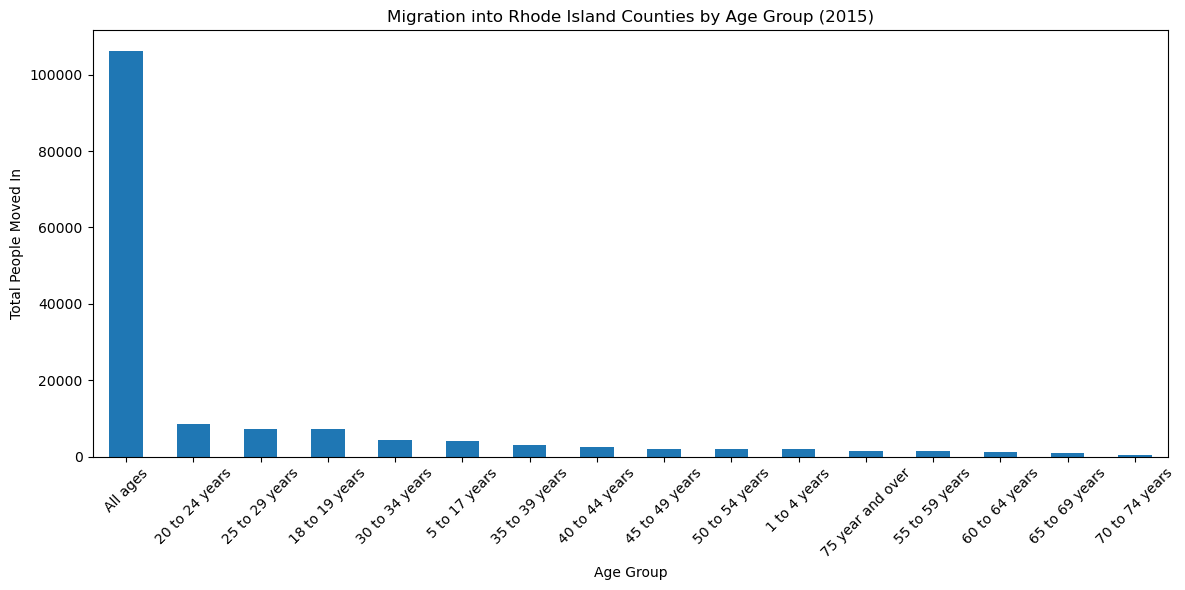

In [8]:
# Analyze migration by age group
if 'AGE_label' in ri_flows_breakdown.columns:
    age_migration = ri_flows_breakdown[ri_flows_breakdown['variable'] == 'MOVEDIN'].groupby('AGE_label')['estimate'].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    age_migration.plot(kind='bar')
    plt.title('Migration into Rhode Island Counties by Age Group (2015)')
    plt.xlabel('Age Group')
    plt.ylabel('Total People Moved In')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Metropolitan Statistical Area Flows

Migration flows are also available at the MSA level (2013+):

In [9]:
# Get MSA-level migration flows
msa_flows = tc.get_flows(
    geography="metropolitan statistical area",
    year=2018,
    output="wide"
)

print(f"MSA flows shape: {msa_flows.shape}")
msa_flows.head()

MSA flows shape: (70428, 10)


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M,MOVEDOUT,MOVEDOUT_M,MOVEDNET,MOVEDNET_M
0,10180,None,"Abilene, TX Metro Area",Outside Metro Area within U.S. or Puerto Rico,3883,508.0,2785.0,410.0,1098.0,684.0
1,10180,None,"Abilene, TX Metro Area",Africa,134,152.0,NaN,NaN,NaN,NaN
2,10180,None,"Abilene, TX Metro Area",Asia,504,207.0,NaN,NaN,NaN,NaN
3,10180,None,"Abilene, TX Metro Area",Central America,56,42.0,NaN,NaN,NaN,NaN
4,10180,None,"Abilene, TX Metro Area",Europe,264,176.0,NaN,NaN,NaN,NaN


In [10]:
# Find the largest MSA flows
largest_msa_flows = msa_flows.nlargest(10, 'MOVEDIN')
print("Largest MSA-to-MSA migration flows:")
for _, row in largest_msa_flows.iterrows():
    print(f"{row['FULL1_NAME']} → {row['FULL2_NAME']}: {row['MOVEDIN']:,} people")

Largest MSA-to-MSA migration flows:
Riverside-San Bernardino-Ontario, CA Metro Area → Los Angeles-Long Beach-Anaheim, CA Metro Area: 85,361 people
New York-Newark-Jersey City, NY-NJ-PA Metro Area → Asia: 65,239 people
Los Angeles-Long Beach-Anaheim, CA Metro Area → Asia: 57,528 people
Los Angeles-Long Beach-Anaheim, CA Metro Area → Riverside-San Bernardino-Ontario, CA Metro Area: 42,989 people
Dallas-Fort Worth-Arlington, TX Metro Area → Outside Metro Area within U.S. or Puerto Rico: 34,853 people
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area → New York-Newark-Jersey City, NY-NJ-PA Metro Area: 31,621 people
Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area → Asia: 31,025 people
Miami-Fort Lauderdale-West Palm Beach, FL Metro Area → Caribbean: 30,633 people
New York-Newark-Jersey City, NY-NJ-PA Metro Area → Europe: 29,904 people
San Francisco-Oakland-Hayward, CA Metro Area → Asia: 29,747 people


## Margin of Error and Confidence Levels

You can adjust the confidence level for margin of error calculations:

In [11]:
# Compare different confidence levels
flows_90 = tc.get_flows(geography="county", state="NY", year=2018, moe_level=90, output="wide")
flows_95 = tc.get_flows(geography="county", state="NY", year=2018, moe_level=95, output="wide")
flows_99 = tc.get_flows(geography="county", state="NY", year=2018, moe_level=99, output="wide")

print("Margin of error comparison for first flow:")
print(f"90% confidence: {flows_90['MOVEDIN_M'].iloc[0]:.1f}")
print(f"95% confidence: {flows_95['MOVEDIN_M'].iloc[0]:.1f}") 
print(f"99% confidence: {flows_99['MOVEDIN_M'].iloc[0]:.1f}")

Margin of error comparison for first flow:
90% confidence: 33.0
95% confidence: 39.3
99% confidence: 51.4


## Geometry Integration for Mapping

Add geographic centroids for mapping migration flows:

In [12]:


# Get flows with geometry
flows_geo = tc.get_flows(
    geography="county",
    state="RI",
    year=2018,
    geometry=True,
    output="wide"
)
flows_geo.tail()

/home/mmann1123/Documents/github/pytidycensus/pytidycensus/flows.py:654: UserWarning: Could not find centroids for 9 GEOIDs: ['09011', '09013', '09001', '02261', '09009'].... These flows will not have geometry data.
  warnings.warn(


,GEOID1,GEOID2,FULL1_NAME,FULL2_NAME,MOVEDIN,MOVEDIN_M,MOVEDOUT,MOVEDOUT_M,MOVEDNET,MOVEDNET_M,centroid1,centroid2
1128,44009,55007,"Washington County, Rhode Island","Bayfield County, Wisconsin",0,30.0,6.0,5.0,-6.0,5.0,POINT (-71.62272 41.46965),POINT (-91.20137011438374 46.52300774226001)
1129,44009,55025,"Washington County, Rhode Island","Dane County, Wisconsin",0,30.0,9.0,13.0,-9.0,13.0,POINT (-71.62272 41.46965),POINT (-89.41818343109118 43.0673096742963)
1130,44009,55079,"Washington County, Rhode Island","Milwaukee County, Wisconsin",0,30.0,14.0,23.0,-14.0,23.0,POINT (-71.62272 41.46965),POINT (-87.96684239379597 43.00702311746134)
1131,44009,55101,"Washington County, Rhode Island","Racine County, Wisconsin",36,56.0,0.0,20.0,36.0,56.0,POINT (-71.62272 41.46965),POINT (-88.0613195061766 42.747515942441765)
1132,44009,72137,"Washington County, Rhode Island","Toa Baja Municipio, Puerto Rico",2,3.0,0.0,32.0,2.0,3.0,POINT (-71.62272 41.46965),POINT (-66.21454600086274 18.431092395056837)


/home/mmann1123/Documents/github/pytidycensus/pytidycensus/flows.py:654: UserWarning: Could not find centroids for 115 GEOIDs: ['0900352140', '0901372090', '0901301080', '0901171670', '0900566420'].... These flows will not have geometry data.
  warnings.warn(


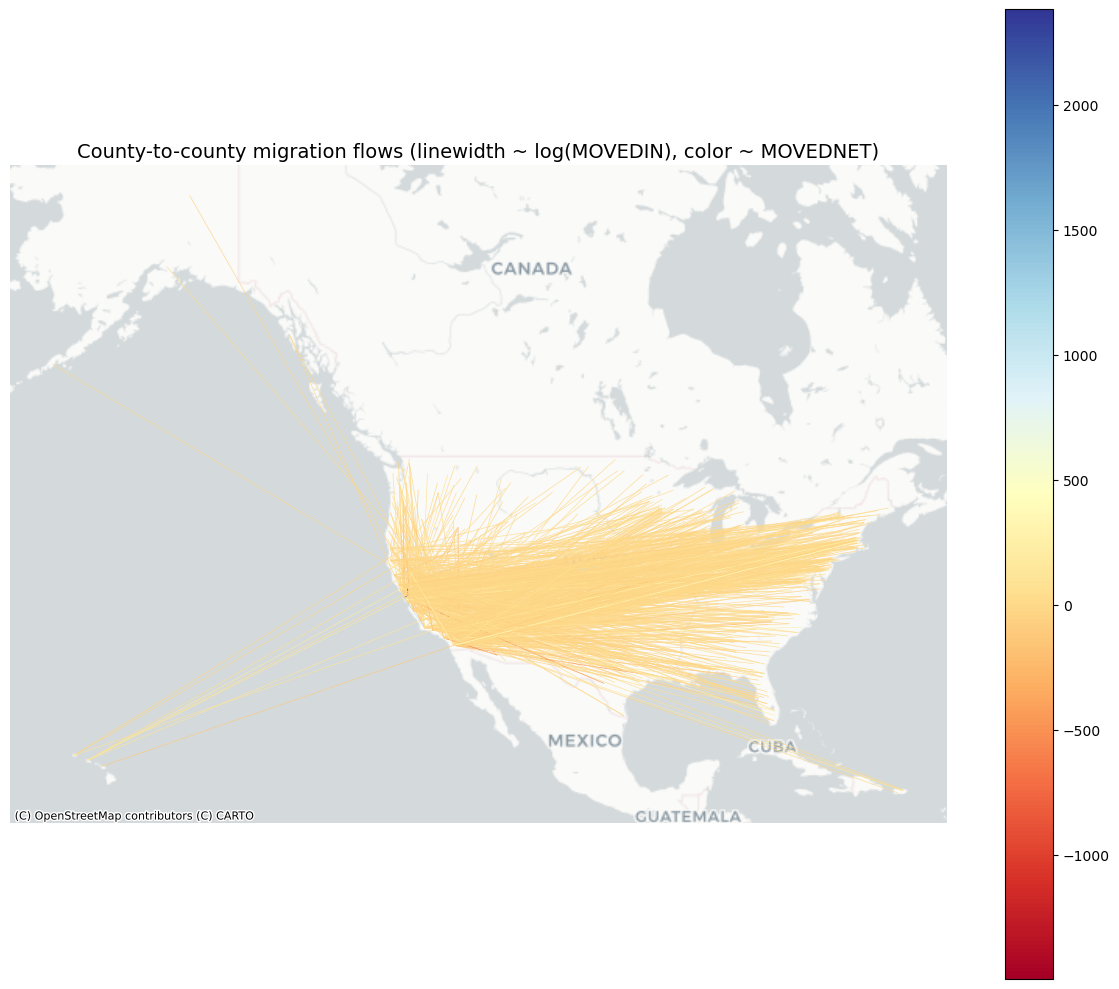

In [13]:
import pytidycensus as tc
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import contextily as ctx 

# Get flows with geometry
flows_geo = tc.get_flows(
    geography="county",
    state="CA",
    year=2018,
    geometry=True,
    output="wide"
)

lines = flows_geo.copy()
lines = lines.dropna(subset=['centroid1', 'centroid2'])

lines['geometry'] = lines.apply(lambda r: LineString([r['centroid1'], r['centroid2']]) , axis=1)
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs=flows_geo.crs)

# project to web mercator for basemap
lines_web = lines.to_crs(epsg=3857)

# dramatic width scaling: use log1p to increase contrast, then map to [min_w, max_w]
min_w, max_w = 0.5, 6.0
vals = np.log1p(lines_web['MOVEDIN'].astype(float).fillna(0))
max_val = vals.max() if vals.max() > 0 else 1.0
lines_web['lw'] = np.interp(vals, [0, max_val], [min_w, max_w])

# draw small flows first, large flows last (so large flows sit on top)
lines_web_sorted = lines_web.sort_values('MOVEDIN', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
lines_web_sorted.sample(1000).plot(
    ax=ax,
    linewidth=lines_web_sorted['lw'],
    column='MOVEDNET',            # color by net migration
    cmap='RdYlBu',
    alpha=0.85,
    legend=True,
    zorder=1
)

# plot origin/destination centroids on top
orig_pts = gpd.GeoDataFrame(geometry=lines[['centroid1']].rename(columns={'centroid1':'geometry'})['geometry'], crs=lines.crs).set_geometry('geometry').to_crs(epsg=3857)
dest_pts = gpd.GeoDataFrame(geometry=lines[['centroid2']].rename(columns={'centroid2':'geometry'})['geometry'], crs=lines.crs).set_geometry('geometry').to_crs(epsg=3857)
# orig_pts.plot(ax=ax, markersize=18, color='black', alpha=0.9, zorder=3)
# dest_pts.plot(ax=ax, markersize=14, color='white', edgecolor='black', alpha=0.9, zorder=4)

# basemap with fallbacks
try:
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
except Exception:
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title('County-to-county migration flows (linewidth ~ log(MOVEDIN), color ~ MOVEDNET)', fontsize=14)
plt.tight_layout()
plt.show()

/home/mmann1123/Documents/github/pytidycensus/pytidycensus/flows.py:654: UserWarning: Could not find centroids for 97 GEOIDs: ['0900579510', '0900156060', '0901385950', '0900949950', '0900174190'].... These flows will not have geometry data.
  warnings.warn(


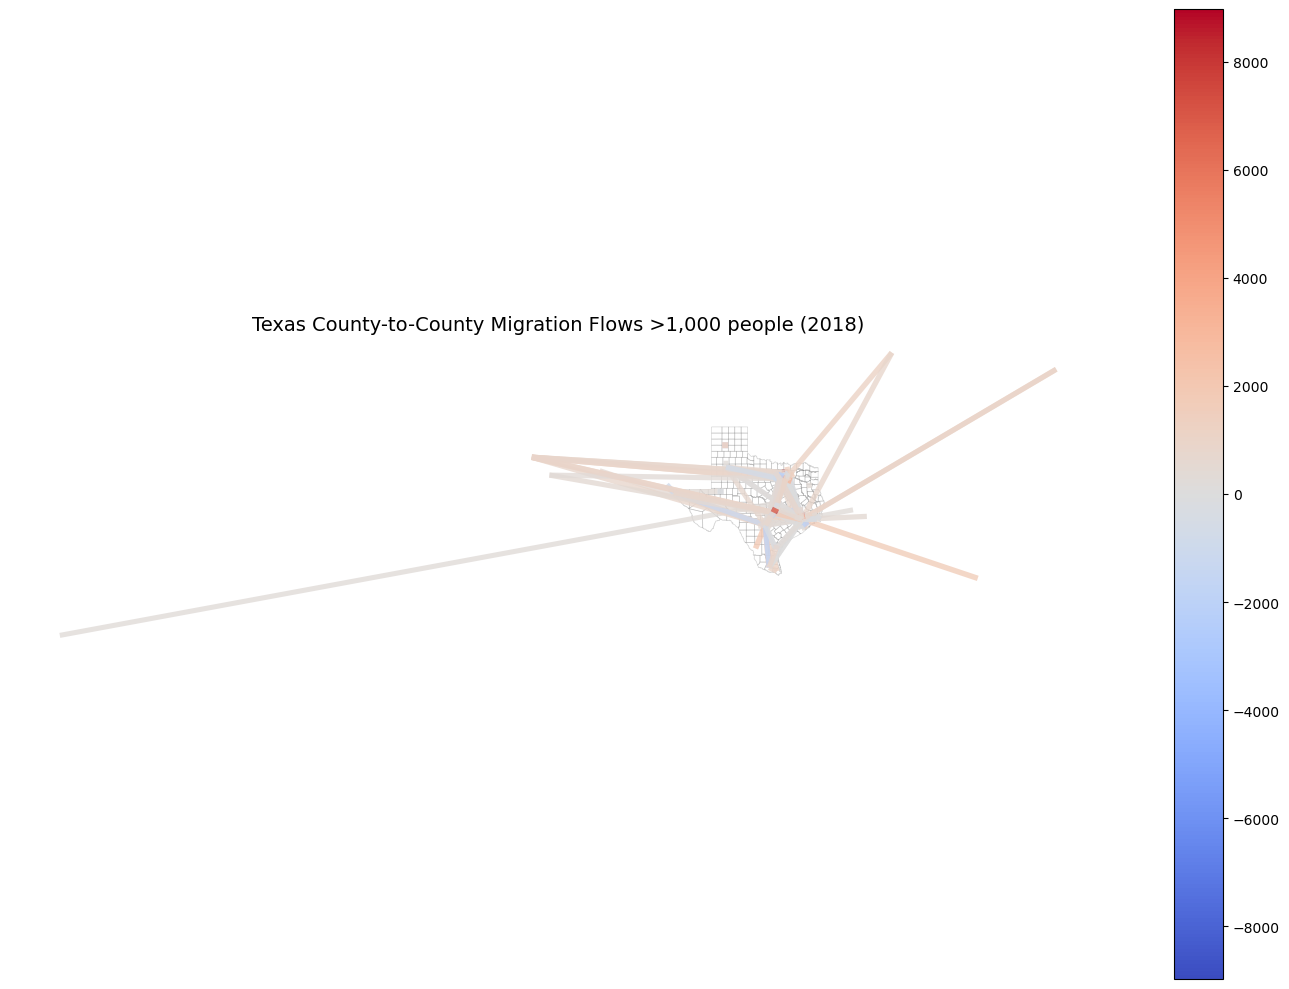

In [14]:

import pytidycensus as tc
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

# Get flows
flows_geo = tc.get_flows(
    geography="county",
    state="TX",
    year=2018,
    geometry=True,
    output="wide"
)

# Get Texas county boundaries for context
tx_counties = tc.get_geography("county", state="TX", year=2018)

# Create flow lines
lines = flows_geo.copy()
lines = lines.dropna(subset=['centroid1', 'centroid2'])
lines['geometry'] = lines.apply(lambda r: LineString([r['centroid1'], r['centroid2']]), axis=1)
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs=flows_geo.crs)

# Filter significant flows
significant_flows = lines[lines['MOVEDIN'] > 1000].copy()

# Calculate line widths
min_w, max_w = 0.5, 5.0
vals = np.log1p(significant_flows['MOVEDIN'].astype(float))
max_val = vals.max() if vals.max() > 0 else 1.0
significant_flows['lw'] = np.interp(vals, [0, max_val], [min_w, max_w])

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# County boundaries as background
tx_counties.boundary.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.3, zorder=1)

# Flow lines
significant_flows.plot(
    ax=ax,
    linewidth=significant_flows['lw'],
    column='MOVEDNET',
    cmap='coolwarm',
    alpha=0.8,
    legend=True,
    zorder=2
)

ax.set_axis_off()
plt.title('Texas County-to-County Migration Flows >1,000 people (2018)', fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
significant_flows.explore(column='MOVEDNET',)

## Error Handling and Best Practices

Here are some common errors and how to handle them:

In [16]:
# Error: Invalid geography
try:
    tc.get_flows(geography="invalid", year=2018)
except ValueError as e:
    print(f"Geography error: {e}")

# Error: Year too early
try:
    tc.get_flows(geography="county", year=2009)
except ValueError as e:
    print(f"Year error: {e}")

# Error: Breakdown variables after 2015
try:
    tc.get_flows(geography="county", breakdown=["AGE"], year=2016)
except ValueError as e:
    print(f"Breakdown error: {e}")

# Error: MSA data before 2013
try:
    tc.get_flows(geography="metropolitan statistical area", year=2012)
except ValueError as e:
    print(f"MSA year error: {e}")

Geography error: Geography must be one of: county, county subdivision, metropolitan statistical area
Year error: Migration flows are available beginning in 2010
Breakdown error: Breakdown characteristics are only available for surveys before 2016
MSA year error: MSA-level data is only available beginning with 2013 (2009-2013 5-year ACS)


## Summary

The `get_flows()` function provides comprehensive access to Census migration flow data with features including:

- **Multiple geographic levels**: county, county subdivision, MSA
- **Flexible output formats**: wide (API format) or tidy (analysis-ready)
- **Demographic breakdowns**: age, sex, race, income, etc. (2006-2015 only)
- **Confidence levels**: 90%, 95%, or 99% for margin of error
- **Geometry integration**: centroids for mapping flows
- **Robust validation**: comprehensive error checking and helpful messages

For more information, see the [pytidycensus documentation](https://mmann1123.github.io/pytidycensus/).